In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('data.csv')
df.head()

,YEAR,MO,DY,HR,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF
0,2021,3,31,18,2.87,0.0,59.62,7.72,100.30,202103
1,2021,3,31,19,2.68,0.0,62.12,7.64,100.38,202103
2,2021,3,31,20,2.34,0.0,66.19,7.88,100.44,202103
3,2021,3,31,21,1.88,0.0,69.12,8.09,100.48,202103
4,2021,3,31,22,1.54,0.0,67.50,8.28,100.52,202103


In [3]:
df['date'] = df['YEAR'].astype('str')+"-"+df['MO'].astype('str')+"-"+df['DY'].astype('str')+"-"+df['HR'].astype('str')+"-00-00"

In [4]:
df.head()

,YEAR,MO,DY,HR,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF,date
0,2021,3,31,18,2.87,0.0,59.62,7.72,100.30,202103,2021-3-31-18-00-00
1,2021,3,31,19,2.68,0.0,62.12,7.64,100.38,202103,2021-3-31-19-00-00
2,2021,3,31,20,2.34,0.0,66.19,7.88,100.44,202103,2021-3-31-20-00-00
3,2021,3,31,21,1.88,0.0,69.12,8.09,100.48,202103,2021-3-31-21-00-00
4,2021,3,31,22,1.54,0.0,67.50,8.28,100.52,202103,2021-3-31-22-00-00


In [5]:
df = df.iloc[:,4:]

In [6]:
from datetime import datetime

def convert_time(column):
    return datetime.strptime(column, "%Y-%m-%d-%H-%M-%S")

df['date'] = df['date'].apply(convert_time)

In [7]:
df.set_index(df['date'], inplace=True)

In [8]:
df.isnull().sum()

TEMP         0
PRCP         0
HMDT         0
WND_SPD      0
ATM_PRESS    0
REF          0
date         0
dtype: int64

In [9]:
df = df.iloc[:,:-1]

<AxesSubplot:xlabel='date', ylabel='TEMP'>

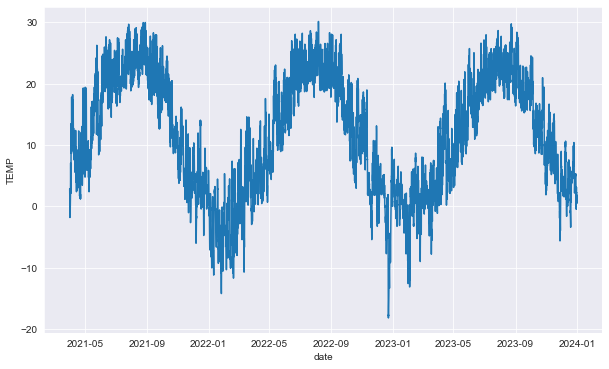

In [10]:
import seaborn as sns
plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df['TEMP'])

In [11]:
df.describe()

,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF
count,24108.000000,24108.000000,24108.000000,24108.000000,24108.000000,24108.000000
mean,11.551965,0.124557,79.210349,5.579917,99.441695,202215.864111
std,9.487944,0.699789,12.649533,2.681790,0.684361,78.813869
min,-18.220000,0.000000,29.310000,0.100000,95.800000,202103.000000
25%,3.580000,0.000000,70.690000,3.600000,99.020000,202112.000000
50%,11.980000,0.000000,80.810000,5.290000,99.440000,202208.000000
75%,20.112500,0.020000,89.190000,7.170000,99.860000,202304.000000
max,30.150000,38.040000,100.000000,17.840000,101.670000,202312.000000


In [12]:
df = df.resample('D').mean()

In [13]:
df.head()

,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF
date,,,,,,
2021-03-31,2.081667,0.00000,64.915000,7.975000,100.441667,202103.0
2021-04-01,-0.224583,0.00125,65.604583,7.149167,101.009583,202104.0
2021-04-02,3.500000,0.00000,56.492083,3.933750,100.916250,202104.0
2021-04-03,8.350417,0.00000,70.635000,7.363750,99.889167,202104.0
2021-04-04,12.342500,0.00000,69.380417,3.229167,99.762083,202104.0


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries, model, freq=None):
    # Perform decomposition
    results = seasonal_decompose(timeseries, model=model, period=freq, extrapolate_trend='freq')
    
    # Plot the decomposition
    decomposition_plot = results.plot()
    
    # Adjust the figure size
    decomposition_plot.set_figwidth(20)
    decomposition_plot.set_figheight(10)
    
    plt.show()

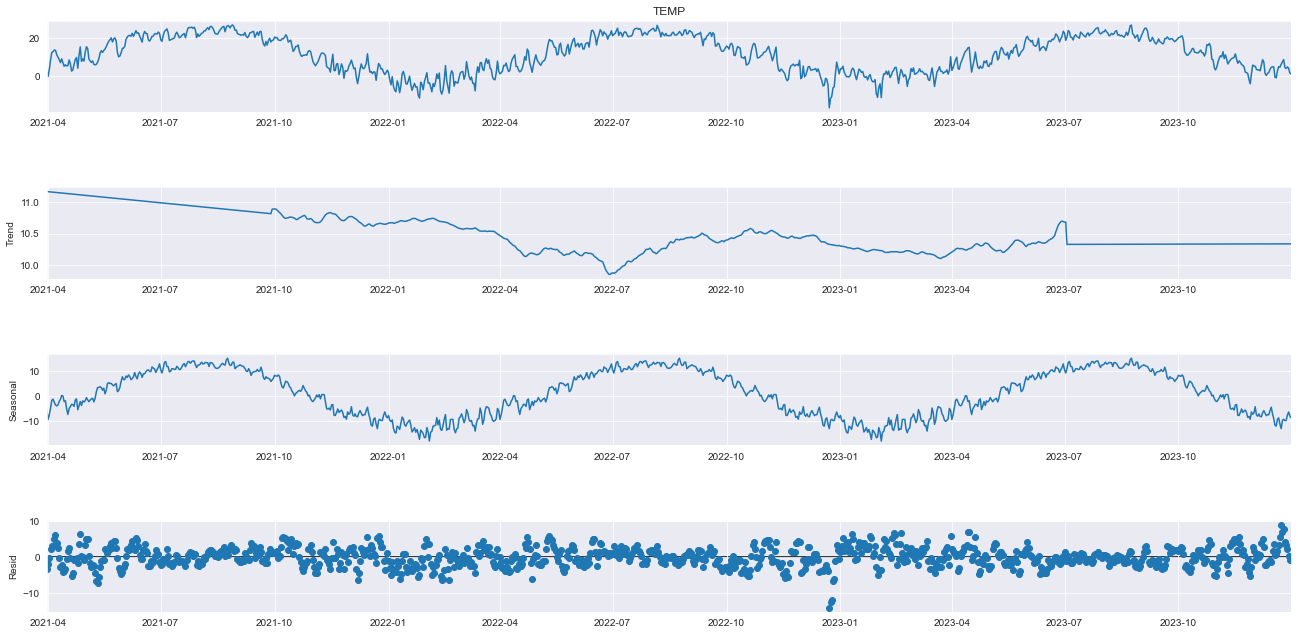

In [15]:
decompose(df['TEMP'], 'additive', 365)

In [16]:
def check_stationary(timeseries):

    result = adfuller(timeseries.values)

    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical value:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print('Stationary')
    else:
        print('Non-stationary')

check_stationary(df['TEMP'])

ADF Statistics: -1.843299
p-value: 0.359186
Critical value:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary


In [17]:
df['temp_pred'] = df['TEMP'].shift(1)
df.head()

,TEMP,PRCP,HMDT,WND_SPD,ATM_PRESS,REF,temp_pred
date,,,,,,,
2021-03-31,2.081667,0.00000,64.915000,7.975000,100.441667,202103.0,NaN
2021-04-01,-0.224583,0.00125,65.604583,7.149167,101.009583,202104.0,2.081667
2021-04-02,3.500000,0.00000,56.492083,3.933750,100.916250,202104.0,-0.224583
2021-04-03,8.350417,0.00000,70.635000,7.363750,99.889167,202104.0,3.500000
2021-04-04,12.342500,0.00000,69.380417,3.229167,99.762083,202104.0,8.350417


In [18]:
df_step1 = df.iloc[1:]

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt
errors = sqrt(mean_squared_error(df_step1['TEMP'], df_step1['temp_pred']))
print('Mean squared error: ', errors)

Mean squared error:  2.4786726222592055


In [20]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [21]:
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
aic_set = set()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_step1['temp_pred'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        

            results = mod.fit()
            aic_set.add((param, param_seasonal, results.aic))
        except Exception as e:
            print("An error occurred:", e)
            continue

smallest_aic_entry = min(aic_set, key=lambda x: x[2])

print("Smallest AIC:", smallest_aic_entry[2])
print("Corresponding param, param_seasonal:", smallest_aic_entry[:2])

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11065D+00    |proj g|=  6.58124D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.681D-07   4.111D+00
  F =   4.1106450429913144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97631D+00    |proj g|=  4.52418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   4.523D-05   2.976D+00
  F =   2.9763063282293749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.89918D+00    |proj g|=  4.89823D-02

At iterate   10    f=  2.89776D+00    |proj g|=  2.76808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   7.467D-07   2.898D+00
  F =   2.8977616358113285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78523D+00    |proj g|=  6.27582D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.77732D+00    |proj g|=  8.58038D-01

At iterate   10    f=  3.53521D+00    |proj g|=  9.69241D-01

At iterate   15    f=  3.50695D+00    |proj g|=  1.23244D-01

At iterate   20    f=  3.50614D+00    |proj g|=  7.16405D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     26      1     0     0   7.164D-07   3.506D+00
  F =   3.5061376046997701     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73746D+00    |proj g|=  6.86427D-01

At iterate    5    f=  2.67118D+00    |proj g|=  3.26477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     10      1     0     0   1.543D-06   2.671D+00
  F =   2.6709490530167903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  3.42284D+00    |proj g|=  6.19577D-01

At iterate   10    f=  2.66439D+00    |proj g|=  1.79265D-01

At iterate   15    f=  2.65502D+00    |proj g|=  3.22545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     31      1     0     0   3.000D-06   2.655D+00
  F =   2.6550185615209294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62295D+00    |proj g|=  5.82294D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  2.59316D+00    |proj g|=  1.24418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   2.882D-06   2.593D+00
  F =   2.5930608610746448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65737D+00    |proj g|=  8.20379D-01

At iterate    5    f=  2.57949D+00    |proj g|=  4.74180D-02


 This problem is unconstrained.



At iterate   10    f=  2.56964D+00    |proj g|=  1.07797D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   3.458D-06   2.570D+00
  F =   2.5696441130334224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64884D+00    |proj g|=  8.61892D-01


 This problem is unconstrained.



At iterate    5    f=  2.57658D+00    |proj g|=  5.30484D-02

At iterate   10    f=  2.56338D+00    |proj g|=  3.29535D-04

At iterate   15    f=  2.56338D+00    |proj g|=  2.95866D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   2.959D-06   2.563D+00
  F =   2.5633835151276880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32258D+00    |proj g|=  4.53710D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.29120D+00    |proj g|=  4.84098D-03

At iterate   10    f=  2.29119D+00    |proj g|=  2.29228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   2.686D-06   2.291D+00
  F =   2.2911903514410144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29644D+00    |proj g|=  4.96190D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.29318D+00    |proj g|=  1.05794D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     25      1     0     0   1.754D-06   2.293D+00
  F =   2.2931755190680079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46518D+00    |proj g|=  6.80158D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.802D-06   2.465D+00
  F =   2.4651791251023227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.3

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31976D+00    |proj g|=  2.72892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   5.052D-07   2.319D+00
  F =   2.3190452824579473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.



At iterate    5    f=  2.28692D+00    |proj g|=  2.86138D-03

At iterate   10    f=  2.28689D+00    |proj g|=  1.72565D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.662D-06   2.287D+00
  F =   2.2868936465860594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29653D+00    |proj g|=  2.00933D-02

At iterate    5    f=  2.29613D+00    |proj g|=  7.72027D-06

       

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.29188D+00    |proj g|=  1.24915D-02

At iterate   10    f=  2.29143D+00    |proj g|=  2.52618D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   5.976D-06   2.291D+00
  F =   2.2914262960236829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48814D+00    |proj g|=  7.56879D-02


 This problem is unconstrained.



At iterate    5    f=  2.46501D+00    |proj g|=  9.37967D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.594D-06   2.465D+00
  F =   2.4650109549028323     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41972D+00    |proj g|=  1.23142D-01


 This problem is unconstrained.



At iterate    5    f=  2.28694D+00    |proj g|=  6.70236D-02

At iterate   10    f=  2.28682D+00    |proj g|=  1.70846D-03

At iterate   15    f=  2.28681D+00    |proj g|=  1.05218D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   1.052D-06   2.287D+00
  F =   2.2868129072248986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32131D+00    |proj g|=  1.79590D-04

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58812D+00    |proj g|=  1.10727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.085D-05   2.588D+00
  F =   2.5881203530860768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41887D+00    |proj g|=  2.20364D-01


 This problem is unconstrained.



At iterate    5    f=  2.30287D+00    |proj g|=  4.12590D-01

At iterate   10    f=  2.28528D+00    |proj g|=  2.30055D-03

At iterate   15    f=  2.28528D+00    |proj g|=  3.33280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     22      1     0     0   3.333D-06   2.285D+00
  F =   2.2852799546882347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75682D+00    |proj g|=  9.58795D-01

At iterate    5    f=  2.31135D+00    |proj g|=  2.45123D-01

At iterate   10    f=  2.29312D+00    |proj g|=  2.57871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     26      1     0     0   1.446D-05   2.293D+00
  F =   2.2930962128061751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42282D+00    |proj g|=  1.53579D-01


 This problem is unconstrained.



At iterate    5    f=  2.33083D+00    |proj g|=  3.48837D-01

At iterate   10    f=  2.28612D+00    |proj g|=  2.11255D-01

At iterate   15    f=  2.28537D+00    |proj g|=  2.95994D-02

At iterate   20    f=  2.28528D+00    |proj g|=  1.55170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   8.504D-06   2.285D+00
  F =   2.2852787976693905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.29034D+00    |proj g|=  6.34393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   5.179D-05   2.290D+00
  F =   2.2903419987101312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56419D+00    |proj g|=  1.18206D-02

At iterate    5    f=  2.56406D+00    |proj g|=  6.16101D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.30485D+00    |proj g|=  1.07383D-01

At iterate   10    f=  2.28142D+00    |proj g|=  2.09101D-02

At iterate   15    f=  2.28107D+00    |proj g|=  7.01308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   1.744D-05   2.281D+00
  F =   2.2810650485183994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75660D+00    |proj g|=  9.61038D-01

At iterate    5    f=  2.31449D+00    |proj g|=  3.59100D-01

At iterate   10    f=  2.29331D+00    |proj g|=  3.37432D-02

At iterate   15    f=  2.29250D+00    |proj g|=  1.59646D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.596D-06   2.292D+00
  F =   2.2924974306853172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40940D+00    |proj g|=  1.41292D-01

At iterate    5    f=  2.31983D+00    |proj g|=  2.14147D-01

At iterate   10    f=  2.29088D+00    |proj g|=  6.94750D-02

At iterate   15    f=  2.28148D+00    |proj g|=  1.50803D-02

At iterate   20    f=  2.28107D+00    |proj g|=  5.38670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     36      1     0     0   5.484D-06   2.281D+00
  F =   2.2810647981839547     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.29098D+00    |proj g|=  3.14539D-03

At iterate   10    f=  2.29095D+00    |proj g|=  1.35829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.358D-06   2.291D+00
  F =   2.2909544918335993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29410D+00    |proj g|=  5.37510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.034D-05   2.294D+00
  F =   2.2940897784201688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42410D+00    |proj g|=  1.23560D-01


 This problem is unconstrained.



At iterate    5    f=  2.29090D+00    |proj g|=  3.85288D-02

At iterate   10    f=  2.29089D+00    |proj g|=  9.20555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     27      1     0     0   8.114D-05   2.291D+00
  F =   2.2908880209447746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31924D+00    |proj g|=  1.07509D-01

At iterate    5    f=  2.29338D+00    |proj g|=  1.49048D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.26055D+00    |proj g|=  1.25312D-01

At iterate   10    f=  2.25780D+00    |proj g|=  6.68963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   2.009D-05   2.258D+00
  F =   2.2577976000316951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65073D+00    |proj g|=  8.64229D-02


 This problem is unconstrained.



At iterate    5    f=  2.59343D+00    |proj g|=  8.09901D-02

At iterate   10    f=  2.58854D+00    |proj g|=  2.63690D-02

At iterate   15    f=  2.58621D+00    |proj g|=  4.80190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   4.210D-06   2.586D+00
  F =   2.5862143497069305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40110D+00    |proj g|=  1.39507D-01


 This problem is unconstrained.



At iterate    5    f=  2.27619D+00    |proj g|=  4.47802D-02

At iterate   10    f=  2.25409D+00    |proj g|=  3.29251D-02

At iterate   15    f=  2.25283D+00    |proj g|=  4.29714D-04

At iterate   20    f=  2.25283D+00    |proj g|=  5.70404D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   5.704D-05   2.253D+00
  F =   2.2528301933817039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  2.25963D+00    |proj g|=  9.82809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   6.931D-06   2.260D+00
  F =   2.2596291756817712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29231D+00    |proj g|=  1.14322D-01


 This problem is unconstrained.



At iterate    5    f=  2.26229D+00    |proj g|=  6.94172D-02

At iterate   10    f=  2.25778D+00    |proj g|=  1.39253D-03

At iterate   15    f=  2.25726D+00    |proj g|=  6.68471D-02

At iterate   20    f=  2.25637D+00    |proj g|=  4.38435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     42      1     0     0   5.124D-05   2.256D+00
  F =   2.2563618721199439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48465D+00    |proj g|=  7.39271D-02

At iterate    5    f=  2.42802D+00    |proj g|=  1.97215D-01

At iterate   10    f=  2.40844D+00    |proj g|=  6.16351D-02

At iterate   15    f=  2.40665D+00    |proj g|=  3.41755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     0     0   2.477D-06   2.407D+00
  F =   2.4066498159719307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41820D+00    |proj g|=  1.24553D-01

At iterate    5    f=  2.27504D+00    |proj g|=  4.79027D-02

At iterate   10    f=  2.25578D+00    |proj g|=  4.03878D-02

At iterate   15    f=  2.25277D+00    |proj g|=  1.32137D-02

At iterate   20    f=  2.25276D+00    |proj g|=  5.15940D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     38      1     0     0   2.504D-05   2.253D+00
  F =   2.2527592408553438     

CONVERG

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40110D+00    |proj g|=  1.39507D-01


 This problem is unconstrained.



At iterate    5    f=  2.27619D+00    |proj g|=  4.47802D-02

At iterate   10    f=  2.25409D+00    |proj g|=  3.29251D-02

At iterate   15    f=  2.25283D+00    |proj g|=  4.29714D-04

At iterate   20    f=  2.25283D+00    |proj g|=  5.70404D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   5.704D-05   2.253D+00
  F =   2.2528301933817039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


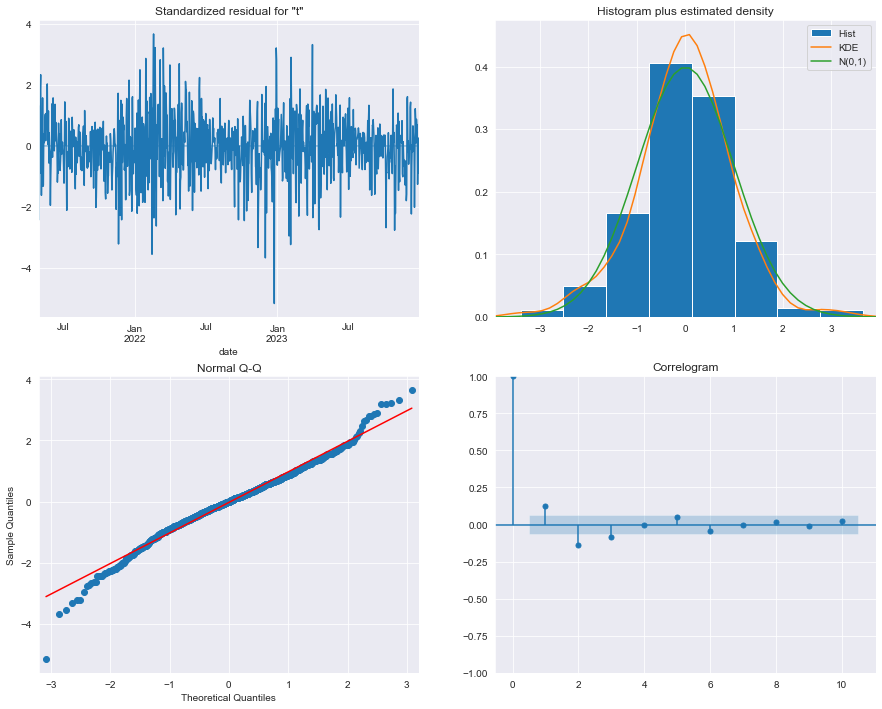

In [22]:
mod = sm.tsa.statespace.SARIMAX(df_step1['temp_pred'],
                                order=(1,1,1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)


results = mod.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
pred = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
pred_ci = pred.conf_int()

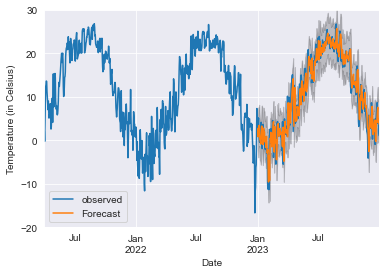

In [24]:
ax = df['TEMP']['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error as MSE

y_forecasted = pred.predicted_mean
y_truth = df['TEMP']['2023-01-01':]  
print(y_forecasted.shape)
print(y_truth.shape)

# Compute the mean square error
mse = MSE(y_truth, y_forecasted)
print('The Mean Squared Error of our forecasts is {:.2f}'.format(mse))

(365,)
(365,)
The Mean Squared Error of our forecasts is 9.56
